# MTH9899 Machine Learning
## Assignment 01
## Student: Xinlu Xiao

### Problem1

We know that $$ \hat{\beta}^R = (X^{T} X + \lambda I)^{-1}X^{T}Y $$

If the input has the dimension is $N \times F$, since there are K folds, for each fold, we can get: 

For $X^{T} X$, time complexity: $\mathcal{O}(\frac{K-1}{K}F^2N)$

For $X^{T} X + \lambda I$, time complexity: $\mathcal{O}(\frac{K-1}{K}F^2N+F)$

For $(X^{T} X + \lambda I)^{-1}$, time complexity: $\mathcal{O}(\frac{K-1}{K}F^2N+F+F^3)$

For $(X^{T} X + \lambda I)^{-1}X^{T}Y$, time complexity: $\mathcal{O}(\frac{K-1}{K}F^2N+F+F^3+\frac{K-1}{K}F^2N+\frac{K-1}{K}FN) = \mathcal{O}(2\frac{K-1}{K}F^2N+F^3+\frac{K-1}{K}FN+F)$

Then for $K$ folds, the time complexity: $$\mathcal{O}(2(K-1)F^2N+KF^3+(K-1)FN+KF) = \mathcal{O}(KF^2N+KF^3)$$

### Problem2

To compute $X_{-i}^{T} X_{-i}$, we can do this by doing the following:

$$
X^{T} X = 
\begin{bmatrix}
X_{1}^{T} & X_{2}^{T} &\dots & X_{i}^{T} &\dots &X_{K}^{T}
\end{bmatrix}
\begin{bmatrix}
X_{1} \\
X_{2} \\
\dots \\
X_{i} \\
\dots \\
X_{K}
\end{bmatrix} = \sum_{j = 1}^{K} X_{j}^{T} X_{j}
$$

Similarly,

$$
X^{T} Y = 
\begin{bmatrix}
X_{1}^{T} & X_{2}^{T} &\dots & X_{i}^{T} &\dots &X_{K}^{T}
\end{bmatrix}
\begin{bmatrix}
Y_{1} \\
Y_{2} \\
\dots \\
Y_{i} \\
\dots \\
Y_{K}
\end{bmatrix} = \sum_{j = 1}^{K} X_{j}^{T} Y_{j}
$$

So to compute $X_{-i}^T X_{-i} $ and $X_{-i}^T Y_{-i}$, we can do the following:
$$ X_{-i}^T X_{-i} = 
\begin{bmatrix}
X_{1}^{T} & X_{2}^{T} &\dots &X_{K}^{T}
\end{bmatrix}
\begin{bmatrix}
X_{1} \\
X_{2} \\
\dots \\
X_{K}
\end{bmatrix} = \sum_{j = 1}^{K} X_{j}^{T} X_{j} - X_{i}^T X_{i}$$

Similarly, we can calculate $X_{-i}^T Y_{-i}$ as:
$$ X_{-i}^T Y_{-i} = 
\begin{bmatrix}
X_{1}^{T} & X_{2}^{T} &\dots &X_{K}^{T}
\end{bmatrix}
\begin{bmatrix}
Y_{1} \\
Y_{2} \\
\dots \\
Y_{K}
\end{bmatrix} = \sum_{j = 1}^{K} X_{j}^{T} Y_{j} - X_{i}^T Y_{i}$$

To efficiently calculate the $ X_{-i}^T X_{-i}$ and $X_{-i}^T Y_{-i}$, we can calculate the $X^{T} X$ and $X^{T} Y$ first, and we don't need to calculate it each time, just need to minus $X_{i}^{T} X_{i}$ and $X_{i}^T Y_{i}$ respectively. 

### Problem3

In [1]:
# import packages
import numpy as np
import tabulate as tab
import time
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def generate_test_data(n,f):
    np.random.seed(1)
    true_betas = np.random.randn(f)
    
    X = np.random.randn(n,f)
    Y = np.random.randn(n) + X.dot(true_betas)
    
    return(X,Y)

In [12]:
def naive_ridge_cv(X,Y,num_folds, lambdas):
    '''Implements a naive (ie slow) Ridge Regression of X against Y. It will take in a list of suggested 
    lambda values and return back the lambda and betas that genertes minimum mean squared error.
    
    Parameters
    ----------
    X: numpy ndarray
       The independent variables, structured as (samples x features)
    Y: numpy ndarray
       The dependent variable,(sample x 1)
    num_folds: int
       The number of folds to use for cross validation
    lambdas: numpy ndarray
       An array of lambda values to test
       
    Returns
    -------
    lamdba_star:float
       The lambda value that represents the min MSE
    beta_star: numpy ndarray
       The optimal betas
    stat_summary: table
       Summary statistics
    '''
    
    # inverse the matrix
    def my_inv(x):
        if len(x.shape) == 1:
            return 1/x
        else:
            return np.linalg.inv(x)
    
    # get the dimension of input X
    N = X.shape[0]  # num of rows
    F = X.shape[1]  # num of cols

    # array to store the out of sample MSE
    out_mse = []
    
    # store the result
    res = [['Lambda'] + ['Beta_{}'.format(i) for i in range(F)] + ['OutMSE']]
    
    for lambda_ in lambdas:
        out_mse_ = 0.0  
        for i in range(num_folds):
            
            # get in and out of sample X, Y
            X_out = X[int(i/num_folds*N):int((i+1)/num_folds*N)]
            X_in = np.concatenate((X[0:int(i/num_folds*N)],X[int((i+1)/num_folds*N):]),axis = 0)
            Y_out = Y[int(i/num_folds*N):int((i+1)/num_folds*N)]
            Y_in = np.concatenate((Y[0:int(i/num_folds*N)],Y[int((i+1)/num_folds*N):]),axis = 0)
            
            # calculate beta
            beta_ridge = my_inv(X_in.T.dot(X_in) + lambda_ * np.eye(F)).dot(X_in.T).dot(Y_in)
            
            # calculate MSE
            out_err = X_out.dot(beta_ridge) - Y_out
            
            # get total MSE for each lambda
            out_mse_ += out_err.T.dot(out_err)/X_out.shape[0]
        out_mse.append(out_mse_)
        
        # get beta for each lambda
        beta_set = my_inv(X.T.dot(X) + lambda_ * np.eye(F)).dot(X.T).dot(Y)
        
        res.append([lambda_] + list(beta_set) + [out_mse_])
    
    # print statistics
    stat_summary = (tab.tabulate(res, headers='firstrow', numalign='right', stralign='right', tablefmt='grid', floatfmt='.4f')) 
    
    # create dataframe to return lambda_star
#    df = pd.DataFrame(lambdas).rename(columns = {0:"lambdas"})
#    df['out_mse'] = pd.DataFrame(out_mse)     
#    lambda_star = df['lambdas'].iloc[df['out_mse'].argmin()]
    
    # get the optimal lambda and corresponding beta 
    lambda_star = lambdas[out_mse.index(min(out_mse))]
    beta_star = my_inv(X.T.dot(X) + lambda_star * np.eye(F)).dot(X.T).dot(Y)
    
    return(lambda_star, beta_star,stat_summary) 

In [13]:
def fast_ridge_cv(X,Y,num_folds, lambdas):
    '''Implement a fast Ridge Regression of X against Y. It will take in a list of suggested lambda 
    values and return back lambda and betas that generates minimum mean squared error.
    
    Parameters
    ----------
    X: numpy ndarray
       The independent variables, structured as (samples x features)
    Y: numpy ndarray
       The dependent variable,(sample x 1)
    num_folds: int
       The number of folds to use for cross validation
    lambdas: numpy ndarray
       An array of lambda values to test
       
    Returns
    -------
    lamdba_star:float
       The lambda value that represents the min MSE
    beta_star: numpy ndarray
       The optimal betas
    stat_summary: table
       Summary statistics
    '''
    # inverse the matrix
    def my_inv(x):
        if len(x.shape) == 1:
            return 1/x
        else:
            return np.linalg.inv(x)
    
    # get the dimension of input X
    N = X.shape[0]  # num of rows
    F = X.shape[1]  # num of cols

    # array to store the out of sample MSE
    out_mse = []
    
    # store the result
    res = [['Lambda'] + ['Beta_{}'.format(i) for i in range(F)] + ['OutMSE']]
    
    # get X.T*X and X.T*Y first
    X_total = X.T.dot(X) 
    Y_total = X.T.dot(Y)
    
    for lambda_ in lambdas:
        out_mse_ = 0.0  
        for i in range(num_folds):
            
            # get in and out of sample X, Y
            X_out = X[int(i/num_folds*N):int((i+1)/num_folds*N)]
            Y_out = Y[int(i/num_folds*N):int((i+1)/num_folds*N)]
            
            # calculate beta
            beta_ridge = my_inv(X_total - X_out.T.dot(X_out)+ lambda_ * np.eye(F)).dot(Y_total - X_out.T.dot(Y_out))
            
            # calculate MSE
            out_err = X_out.dot(beta_ridge) - Y_out
            
            # get total MSE for each lambda
            out_mse_ += out_err.T.dot(out_err)/X_out.shape[0]
        out_mse.append(out_mse_)
        
        # get beta for each lambda
        beta_set = my_inv(X.T.dot(X) + lambda_ * np.eye(F)).dot(X.T).dot(Y)
        
        res.append([lambda_] + list(beta_set) + [out_mse_])
        
    # print statistics
    stat_summary = (tab.tabulate(res, headers='firstrow', numalign='right', stralign='right', tablefmt='grid', floatfmt='.4f')) 
    
    # get the optimal lambda and corresponding beta
    lambda_star = lambdas[out_mse.index(min(out_mse))]
    beta_star = my_inv(X.T.dot(X) + lambda_star * np.eye(F)).dot(X.T).dot(Y)
    
    return(lambda_star, beta_star, stat_summary) 

In [14]:
# print the result: lambda and beta
def print_result(result):
    '''print the result of the Ridge Regression 
    Parameters
    ----------
    result: tuples
           the function result of naive_ridge_cv or fast_ridge_cv
    '''
    lambda_star = result[0]
    beta_star = result[1]
    stat_summary = result[2]
    print("Optimal Lambda: ", lambda_star)
    print("Optimal Beta: ", beta_star)
    print(stat_summary)

In [15]:
# test
X = generate_test_data(1000,5)[0]
Y = generate_test_data(1000,5)[1]
lambdas = [0.0, 0.25, 0.5, 1.0, 1.5, 2.5, 5.0, 7.5, 10.0, 25.0] # 10 reasonable lambdas

In [16]:
# test the naive way
result_naive = naive_ridge_cv(X,Y,10,lambdas)
result_naive
print_result(result_naive)

Optimal Lambda:  1.5
Optimal Beta:  [ 1.59961225 -0.67774458 -0.52116151 -1.06714453  0.83243056]
+----------+----------+----------+----------+----------+----------+----------+
|   Lambda |   Beta_0 |   Beta_1 |   Beta_2 |   Beta_3 |   Beta_4 |   OutMSE |
+==========+==========+==========+==========+==========+==========+==========+
|   0.0000 |   1.6021 |  -0.6787 |  -0.5217 |  -1.0685 |   0.8334 |   9.9921 |
+----------+----------+----------+----------+----------+----------+----------+
|   0.2500 |   1.6017 |  -0.6785 |  -0.5216 |  -1.0683 |   0.8333 |   9.9921 |
+----------+----------+----------+----------+----------+----------+----------+
|   0.5000 |   1.6013 |  -0.6784 |  -0.5215 |  -1.0680 |   0.8331 |   9.9920 |
+----------+----------+----------+----------+----------+----------+----------+
|   1.0000 |   1.6004 |  -0.6781 |  -0.5213 |  -1.0676 |   0.8328 |   9.9920 |
+----------+----------+----------+----------+----------+----------+----------+
|   1.5000 |   1.5996 |  -0.6777 

In [17]:
# test the fast way
result_fast = fast_ridge_cv(X,Y,10,lambdas)
result_fast
print_result(result_fast)

Optimal Lambda:  1.5
Optimal Beta:  [ 1.59961225 -0.67774458 -0.52116151 -1.06714453  0.83243056]
+----------+----------+----------+----------+----------+----------+----------+
|   Lambda |   Beta_0 |   Beta_1 |   Beta_2 |   Beta_3 |   Beta_4 |   OutMSE |
+==========+==========+==========+==========+==========+==========+==========+
|   0.0000 |   1.6021 |  -0.6787 |  -0.5217 |  -1.0685 |   0.8334 |   9.9921 |
+----------+----------+----------+----------+----------+----------+----------+
|   0.2500 |   1.6017 |  -0.6785 |  -0.5216 |  -1.0683 |   0.8333 |   9.9921 |
+----------+----------+----------+----------+----------+----------+----------+
|   0.5000 |   1.6013 |  -0.6784 |  -0.5215 |  -1.0680 |   0.8331 |   9.9920 |
+----------+----------+----------+----------+----------+----------+----------+
|   1.0000 |   1.6004 |  -0.6781 |  -0.5213 |  -1.0676 |   0.8328 |   9.9920 |
+----------+----------+----------+----------+----------+----------+----------+
|   1.5000 |   1.5996 |  -0.6777 

In [31]:
def plot_time(n_start, n_end, f, num_folds, lambdas):
    '''Plot the execution time of both functions as a function of N
    Parameters
    ----------
    n_start: int
             The start of N
    n_end: int
             The end of N
    num_folds: int
             The number of folds to use for cross validation
    lambdas: array
             An array of lambda values to test
    '''
    
    # create array to store the execution time for each n
    naive_time = []
    fast_time = []
    
    # x axis of the plot figure
    x_axis = []
    
    for n in range(n_start, n_end):
        # generate samples
        X = generate_test_data(n,f)[0]
        Y = generate_test_data(n,f)[1]
        
        # calculate execution time for naive way
        start_time1 = time.time()
        result_naive = naive_ridge_cv(X,Y,num_folds,lambdas)
        end_time1 = time.time()
    
        naive_time_ = end_time1 - start_time1
        
        # calculate execution time for fast way
        start_time2 = time.time()
        result_fast = fast_ridge_cv(X,Y,num_folds, lambdas)
        end_time2 = time.time()
        
        fast_time_ = end_time2 - start_time2
        
        # append to the array
        naive_time.append(naive_time_)
        fast_time.append(fast_time_)
        x_axis.append(n)
    
    # plot
    plt.figure(figsize=(16,8),dpi= 120)
    plt.plot(x_axis,naive_time,c = 'blue',label = 'naive execution time')
    plt.plot(x_axis,fast_time,c='orange',label = 'fast execution time')
    plt.title("Naive execution time vs Fast execution time")
    plt.legend(loc='upper right')
    plt.ylabel("time size")
    plt.xlabel("n")  

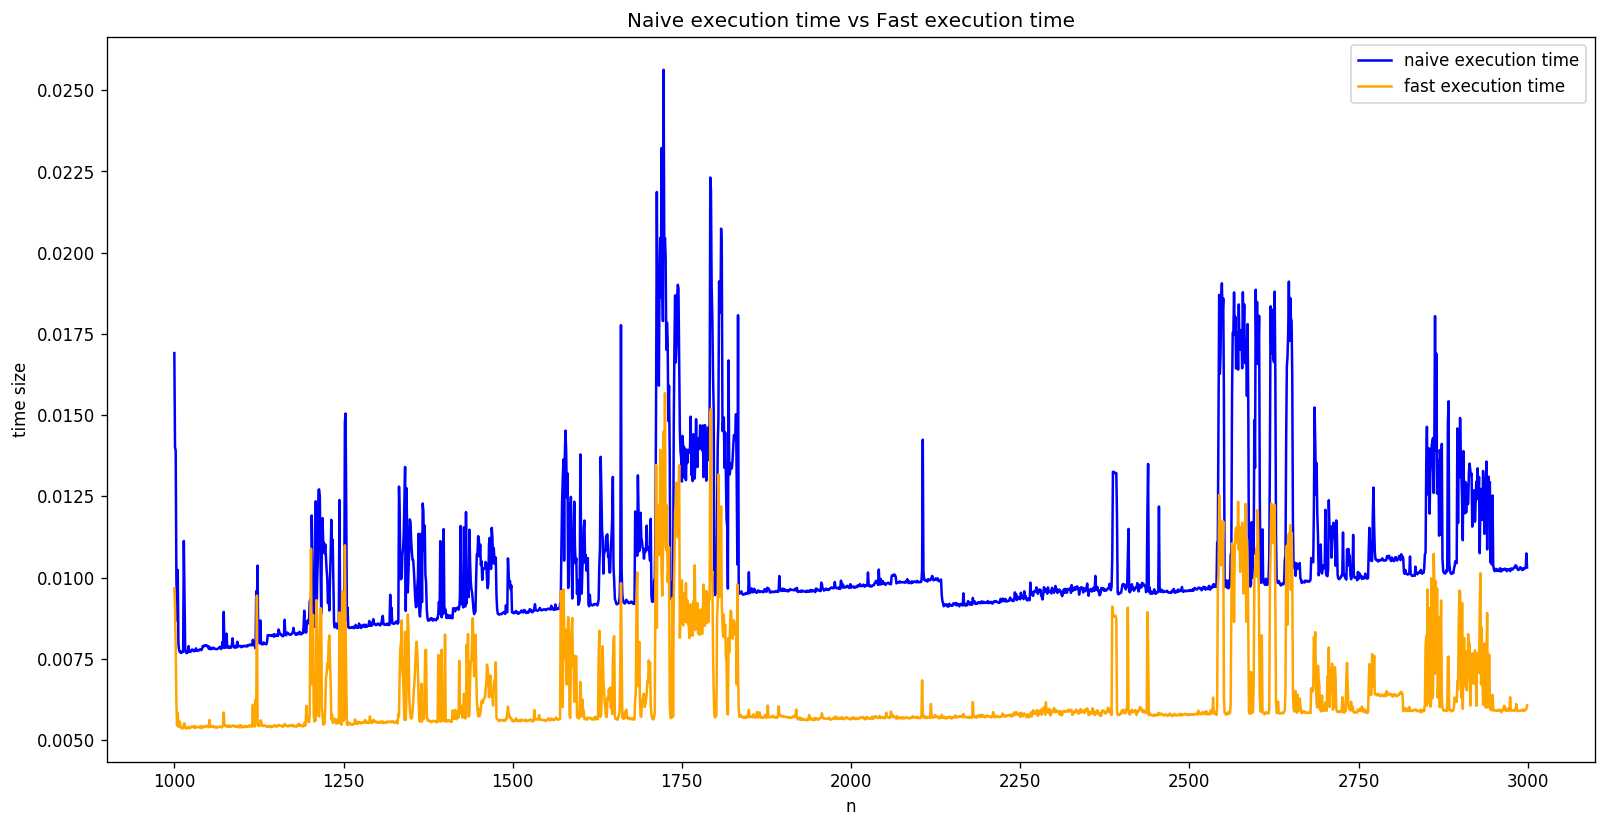

In [32]:
# test with cols number = 5
plot_time(1000,3000,5,10,lambdas)

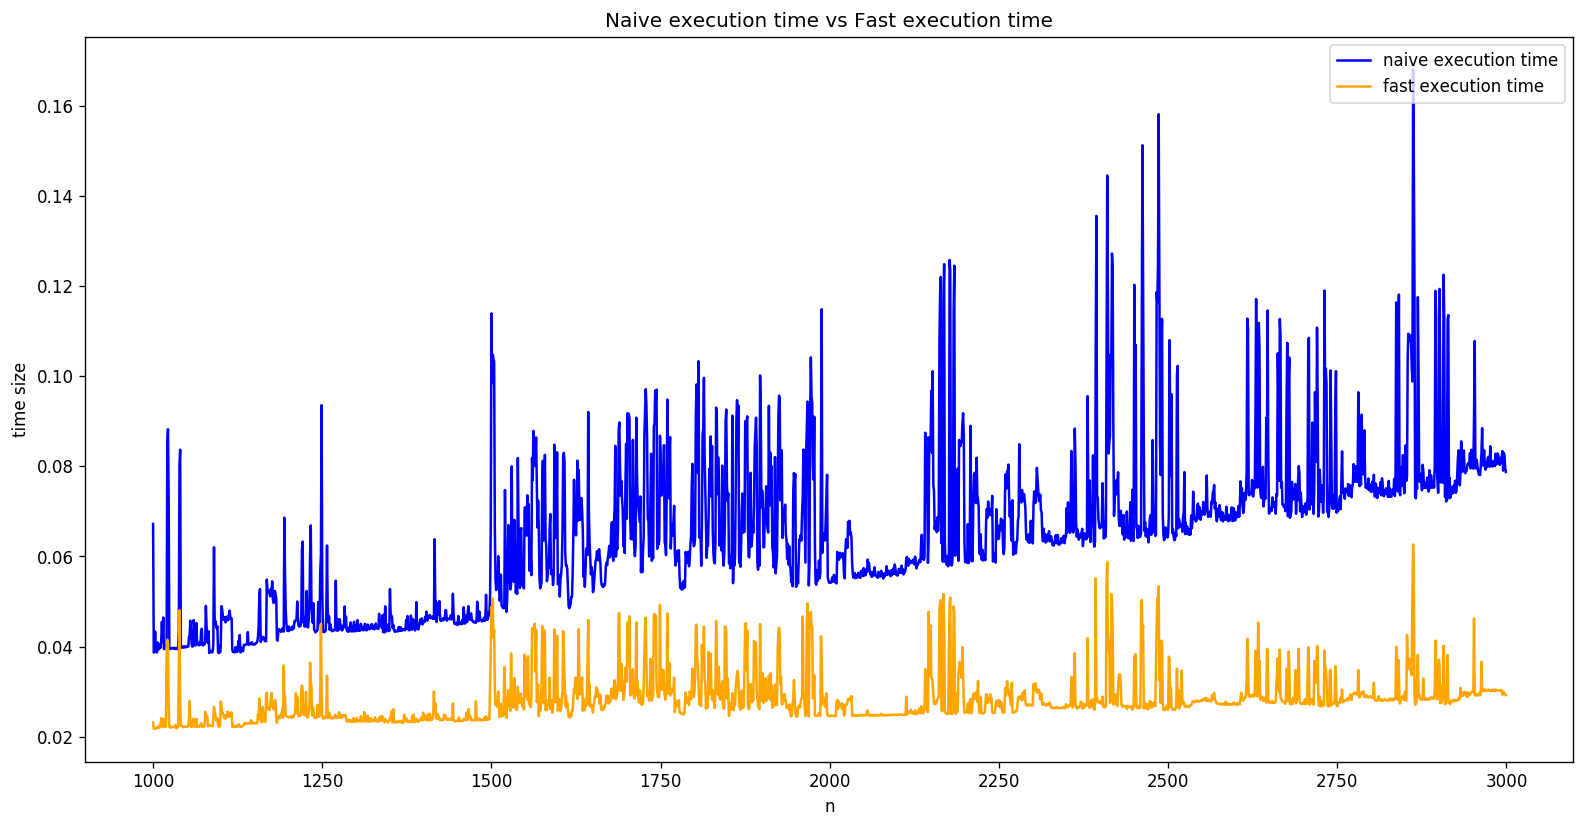

In [34]:
# test with cols number = 5
plot_time(1000,3000,50,10,lambdas)